# Clustering

## Spectral Clustering

#### **Code Overview**

```
n_neighbors = 3
n_clusters = 20
```

**Option 1**: Can feed original data to clustering algorithm (with `affinity='nearest_neighbors'`) and ask it to cluster the data using nearest neighbors 

```
spc = SpectralClustering(n_clusters=n_clusters, n_neighbors=n_neighbors, affinity='nearest_neighbors', random_state=42)
labels = spc.fit_predict(X) 
```

**Option 2**: Alternately, we can split this up into 2 (or possibly 3) steps where we use the original data to compute a graph first (which uses knearest neighbors method) and then feed the graph to the clustering algorithm (with `affinity='precomputed'`) instead of feeding the data directly. 

* You can feed X directly to `kneighbors_graph` or create a `BallTree` with X first and feed the `BallTree` to `kneighbors_graph`
* `BallTree` ([click here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html)) is essentially returning a structure where you can query the nearest nodes to a particular node and their distances.
* Difference between `BallTree` and `kneighbors_graph`
    - `BallTree` gives the ability to say "Give me the 2 closest neighbors" or "Give me the 5 closest neighbors" (see detailed section below for how this is queried)
    - `kneighbors_graph` is computed for a single value of n_neighbors

```
from sklearn.neighbors import BallTree
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import SpectralClustering

tree = BallTree(X, leaf_size=2)
A3 = kneighbors_graph(tree, n_neighbors=n_neighbors, mode='connectivity', include_self=True)
spc = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=42)
labels = spc.fit_predict(A3) 
```

**Option 3**: While Option 1 and 2 are essentially doing the same thing, we can use a variant of option 1 by using a different affinity (`affinity='rbf'`). 

### Sometimes, you have the graph (or [affinity matrix](https://deepai.org/machine-learning-glossary-and-terms/affinity-matrix)) available. In that case, you can still cluster the graph by using option 2 directly See below as per [scikit documentation](https://scikit-learn.org/stable/modules/clustering.html).

```
2.3.5.2. Spectral Clustering Graphs

Spectral Clustering can also be used to partition graphs via their spectral embeddings. In this case, the affinity matrix is the adjacency matrix of the graph, and SpectralClustering is initialized with affinity='precomputed':

```

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np

X = [
    [1,1,1,0,0,0,0],
    [1,0,1,0,0,0,0],
    [1,1,1,0,0,0,0],
    [0,0,0,1,1,1,1],
    [0,0,0,1,1,1,1],
    [0,0,0,1,1,3,3],
    [0,0,0,1,1,3,3]
]
X = np.asarray(X)
X

array([[1, 1, 1, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 3, 3],
       [0, 0, 0, 1, 1, 3, 3]])

#### What the BallTree and kneighbors_graph is doing is basically defining the nearest `n_neighbors` to each observation 

Example below shows the graph with 2 nearest neighbors.
Observation 1 is closest to itself and observation 3.
Observation 3 is closest to itself and observation 1.
Observation 2 is closest to itself and observation 1

**Note that this may or may not be symmetic. Example observation 1 is closest to observation 3 and vice versa, but that is not the case for observation 1 ansd 2. Observation 2 is closest to observation 1 but observation 1 is not closest to observation 2.**


In [2]:
from sklearn.neighbors import BallTree
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import SpectralClustering

tree = BallTree(X, leaf_size=2)
graph = kneighbors_graph(tree, n_neighbors=2, mode='connectivity', include_self=True)
graph.toarray()

array([[1., 0., 1., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1.]])

**Same example as above with n_neighbors=3**

In [3]:
tree = BallTree(X, leaf_size=2)
graph = kneighbors_graph(tree, n_neighbors=3, mode='connectivity', include_self=True)
graph.toarray()

array([[1., 1., 1., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0.],
       [0., 1., 0., 1., 1., 0., 0.],
       [0., 1., 0., 1., 1., 0., 0.],
       [0., 0., 0., 1., 0., 1., 1.],
       [0., 0., 0., 1., 0., 1., 1.]])

**Once we have deinfed the graph, we can use it to cluster.**

So if we take n_neighbors=2 and ask for 3 clusters.

* Clustering
    - It clubs obs 1 and 3 --> (1,3)
    - It clubs obs 6 and 7 --> (6,7)
    - It clubs obs 4 and 5 --> (4,5)
    - Obs 2 is left. It is closest to obs 1 so we put it in that cluster. Final clusters

**Final Clusters**

* Cluster 1: Obs (1,3,2)
* Cluster 2: Obs (6,7)
* Cluster 3: Obs (4,5)

In [4]:
tree = BallTree(X, leaf_size=2)
graph = kneighbors_graph(tree, n_neighbors=2, mode='connectivity', include_self=True)
spc = SpectralClustering(n_clusters=3, affinity='precomputed', random_state=42)
labels = spc.fit_predict(graph) 
print(f"Assigned Labels: {labels}")

Assigned Labels: [1 1 1 0 0 2 2]


#### **Ofcourse, this was a simple example, and I choose n_neighbors and n_clusters based on prior knowlege of how these should be clustered. But in reality we are looking at an unsupervised probelem. So we dont know how many neighbors to use and how many clusters to build, so we use a grid search approach as below.**

#### **The problem with this approach is that each combination of hyperparameters can give a different set of clustering (see below). So we will eventually need some sort of ensemble approach to pick the most likely clusters based on concensus or some other means.**

In [5]:
for n_clusters in np.arange(2,4):
    print(f"\nn_clusters: {n_clusters}")
    for n_neighbors in np.arange(2,7):
        tree = BallTree(X, leaf_size=2)
        graph = kneighbors_graph(tree, n_neighbors=n_neighbors, mode='connectivity', include_self=True)
        spc = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=42)
        labels = spc.fit_predict(graph) 
        print(f"n_neighbors: {n_neighbors} | Assigned Labels: {labels}")


n_clusters: 2
n_neighbors: 2 | Assigned Labels: [1 1 1 0 0 1 1]
n_neighbors: 3 | Assigned Labels: [1 1 1 0 0 0 0]
n_neighbors: 4 | Assigned Labels: [1 1 1 0 1 0 0]
n_neighbors: 5 | Assigned Labels: [0 0 0 0 0 1 1]
n_neighbors: 6 | Assigned Labels: [0 0 0 0 0 1 1]

n_clusters: 3
n_neighbors: 2 | Assigned Labels: [1 1 1 0 0 2 2]
n_neighbors: 3 | Assigned Labels: [1 1 1 0 0 2 2]
n_neighbors: 4 | Assigned Labels: [2 2 2 0 0 1 1]
n_neighbors: 5 | Assigned Labels: [1 1 1 0 1 2 2]
n_neighbors: 6 | Assigned Labels: [1 1 1 0 0 0 2]


#### **For simplicity, the above steps can also be condensed into 1 single call to Spectral Clustering as shown below.**

In [6]:
for n_clusters in np.arange(2,4):
    print(f"\nn_clusters: {n_clusters}")
    for n_neighbors in np.arange(2,7):
        spc = SpectralClustering(n_clusters=n_clusters, n_neighbors=n_neighbors, affinity='nearest_neighbors', random_state=42)
        labels = spc.fit_predict(X) 
        print(f"n_neighbors: {n_neighbors} | Assigned Labels: {labels}")


n_clusters: 2
n_neighbors: 2 | Assigned Labels: [1 1 1 0 0 1 1]
n_neighbors: 3 | Assigned Labels: [1 1 1 0 0 0 0]
n_neighbors: 4 | Assigned Labels: [1 1 1 1 0 0 0]
n_neighbors: 5 | Assigned Labels: [0 0 0 0 0 1 1]
n_neighbors: 6 | Assigned Labels: [0 0 0 0 0 1 1]

n_clusters: 3
n_neighbors: 2 | Assigned Labels: [1 1 1 0 0 2 2]
n_neighbors: 3 | Assigned Labels: [1 1 1 0 0 2 2]
n_neighbors: 4 | Assigned Labels: [1 1 1 0 0 2 2]
n_neighbors: 5 | Assigned Labels: [1 1 1 0 1 2 2]
n_neighbors: 6 | Assigned Labels: [0 0 2 0 0 1 1]


# ________________________________________________________________

# More Details

## K Neighbor Graph

In [7]:
from sklearn.neighbors import kneighbors_graph

In [8]:
X = [[0], [3], [1]]
X

[[0], [3], [1]]

In [9]:
A = kneighbors_graph(X, n_neighbors=2, mode='connectivity', include_self=True)
A.toarray()

array([[1., 0., 1.],
       [0., 1., 1.],
       [1., 0., 1.]])

In [10]:
# ?kneighbors_graph

## Ball Tree 

In [11]:
import numpy as np
from sklearn.neighbors import BallTree

In [12]:
rng = np.random.RandomState(0)
X = rng.random_sample((10, 3))  # 10 points in 3 dimensions
X

array([[0.5488135 , 0.71518937, 0.60276338],
       [0.54488318, 0.4236548 , 0.64589411],
       [0.43758721, 0.891773  , 0.96366276],
       [0.38344152, 0.79172504, 0.52889492],
       [0.56804456, 0.92559664, 0.07103606],
       [0.0871293 , 0.0202184 , 0.83261985],
       [0.77815675, 0.87001215, 0.97861834],
       [0.79915856, 0.46147936, 0.78052918],
       [0.11827443, 0.63992102, 0.14335329],
       [0.94466892, 0.52184832, 0.41466194]])

In [13]:
tree = BallTree(X, leaf_size=2)              

In [14]:
# First Row
X[:1]

array([[0.5488135 , 0.71518937, 0.60276338]])

In [15]:
# Finds the 3 closest neighbors to the 1st observation (including self)
dist, ind = tree.query(X[:1], k=3)           
print(ind)  # indices of 3 closest neighbors
print(dist)  # distances to 3 closest neighbors

[[0 3 1]]
[[0.         0.19662693 0.29473397]]


In [16]:
# Finds the 3 closest neighbors to the all observations (including self)
dist, ind = tree.query(X, k=3)           
print(ind)  # indices of 3 closest neighbors

[[0 3 1]
 [1 7 0]
 [2 6 0]
 [3 0 1]
 [4 3 8]
 [5 1 7]
 [6 2 7]
 [7 1 0]
 [8 3 4]
 [9 7 1]]


#### This means that 
* for the first observation (index 0), the closest neighbors are the 1st one (self, index 0), the second one (index 1) and the 4th one (index 3)
* for the second observation (index 1), the closest neighbors are the 2nd one (self, index 1), the first one (index 0) and the 8th one (index 7)

In [17]:
# ?tree.query

### **Does it scale to larger matrices?**

#### **In my experiments, it works well for 100 x 100, but was very slow for 10,000 x 10,000**

In [18]:
rng = np.random.RandomState(0)
X = rng.random_sample((100, 100))  # NxN dimensions (connectivity type)
X.shape

(100, 100)

In [19]:
tree = BallTree(X, leaf_size=2)

In [20]:
# Finds the 3 closest neighbors to the all observations (including self)
dist, ind = tree.query(X[:1], k=3)           
print(ind)  # indices of 3 closest neighbors

[[ 0 31 69]]


In [21]:
obs = 1
neighbors = np.arange(2,7,1)
for neighbor in neighbors:
    dist, ind = tree.query(X[obs:(obs+1),:], k=neighbor)
    print(f"Indices: {ind}")
    print(f"Distance: {dist}")

Indices: [[ 1 85]]
Distance: [[0.         3.50543674]]
Indices: [[ 1 85 70]]
Distance: [[0.         3.50543674 3.67952152]]
Indices: [[ 1 85 70 25]]
Distance: [[0.         3.50543674 3.67952152 3.70423425]]
Indices: [[ 1 85 70 25 83]]
Distance: [[0.         3.50543674 3.67952152 3.70423425 3.71372323]]
Indices: [[ 1 85 70 25 83 50]]
Distance: [[0.         3.50543674 3.67952152 3.70423425 3.71372323 3.71752065]]


In [22]:
obs = 85
neighbors = np.arange(2,7,1)
for neighbor in neighbors:
    dist, ind = tree.query(X[obs:(obs+1),:], k=neighbor)
    print(f"Indices: {ind}")
    print(f"Distance: {dist}")    

Indices: [[85 23]]
Distance: [[0.         3.43533837]]
Indices: [[85 23 48]]
Distance: [[0.         3.43533837 3.45639274]]
Indices: [[85 23 48 20]]
Distance: [[0.         3.43533837 3.45639274 3.47689528]]
Indices: [[85 23 48 20 93]]
Distance: [[0.         3.43533837 3.45639274 3.47689528 3.48340549]]
Indices: [[85 23 48 20 93  1]]
Distance: [[0.         3.43533837 3.45639274 3.47689528 3.48340549 3.50543674]]


#### <font color=red>**From above, note an inportant point that the distance metric is not symmetric. 1 is closest to 85 bt that does not mean 85 is closest to 1. In fact it is closest to 23 in the above example.**</font>

## Ball Tree --> Neighbor Graph 

#### You can feed the ball tree object to the kneighbors graphs which will basically query this ball tree to find the nearest points and cluster them accordingly.

#### **2 neighbors**

In [23]:
graph2 = kneighbors_graph(tree, 2, mode='connectivity', include_self=True)

In [24]:
graph2.toarray()[1]  ## Looks like index 1 and index 85 are the closest to each other (also seen in tree.query above).

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [25]:
graph2.toarray()[85]  # yes confirmed, the matrix is symmetric

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

#### **3 neighbors**

In [26]:
graph3 = kneighbors_graph(tree, 3, mode='connectivity', include_self=True)

In [27]:
graph3.toarray()[1]  ## Looks like index 1, 85, and 70 are the closest to each other (also seen in tree.query above).

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [28]:
n_clusters = 20

## Clustering based on Ball Tree and K-Nearest Graph

### Note that the clusters depend highly on the the value of K used in the K-nearest Graph as was shown in the introductory section above

### Using 2 neighbors

In [29]:
## Using Precomputed Tree
from sklearn.cluster import SpectralClustering
spc = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=42)
labels = spc.fit_predict(graph2) 
labels

array([ 0, 13, 10,  0,  9,  0,  9,  9,  0,  2, 11,  8, 11,  2, 15,  0,  1,
        0,  7,  0,  0,  0,  1,  1,  4,  1, 11,  1,  0,  0,  0,  0,  6,  1,
       18,  0,  0,  0,  1,  8,  4,  0,  0,  0,  0,  0,  8,  0,  1,  1,  8,
        0,  2,  0,  0,  0,  1,  0, 12,  1,  1,  0,  0,  0,  4,  4,  0,  0,
        0,  0, 17,  0,  0,  3,  0,  0,  0, 14,  0,  1,  0,  1,  7, 14, 17,
        1,  0,  0, 16,  0, 18,  5,  0,  0,  0,  0, 18,  3, 19,  6])

### Using 3 neighbors

#### Using Precomputed Tree

In [30]:
from sklearn.cluster import SpectralClustering
spc = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=42)
labels = spc.fit_predict(graph3) 
labels

array([ 3,  8,  6,  0,  1, 15,  1,  1, 12,  7, 13,  5,  1,  7, 19, 17, 11,
        2, 15,  3,  4,  2,  4, 16, 10,  4,  1, 12, 10,  4,  9,  3, 13,  9,
        4, 18, 17,  0, 14,  0,  8,  2, 18,  0,  8,  8,  0, 16, 12,  7,  0,
        2,  7,  8,  2, 19, 12,  5, 16,  4, 14,  9, 17,  5,  8,  5,  5, 18,
        2,  3,  8, 12, 12,  9,  6,  2, 19, 11, 16, 14, 19, 11, 15, 11,  7,
       16,  6, 17, 15,  6,  4,  8,  8,  2,  5, 17,  4,  9,  4, 13])

#### Alternate: Using original data with n_neighbors=3 instead of creating a nearest neighbor graph first (**results same as above**)

In [31]:
spc = SpectralClustering(n_clusters=n_clusters, n_neighbors=3, affinity='nearest_neighbors', random_state=42)
labels = spc.fit_predict(X) 
labels

array([ 3,  8,  6,  0,  1, 15,  1,  1, 12,  7, 13,  5,  1,  7, 19, 17, 11,
        2, 15,  3,  4,  2,  4, 16, 10,  4,  1, 12, 10,  4,  9,  3, 13,  9,
        4, 18, 17,  0, 14,  0,  8,  2, 18,  0,  8,  8,  0, 16, 12,  7,  0,
        2,  7,  8,  2, 19, 12,  5, 16,  4, 14,  9, 17,  5,  8,  5,  5, 18,
        2,  3,  8, 12, 12,  9,  6,  2, 19, 11, 16, 14, 19, 11, 15, 11,  7,
       16,  6, 17, 15,  6,  4,  8,  8,  2,  5, 17,  4,  9,  4, 13])

## **Checking distribution of cluster sizes based on n_neighbors in the graph**

#### **Again as observed above, the number of points in each cluster can vary a lot depending on the value of n_neighbors**

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

Neighbors = 2
Count of observations in each cluster (sorted): [48, 15, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1]


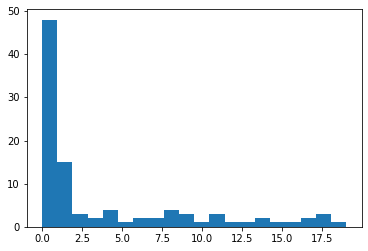

Neighbors = 3
Count of observations in each cluster (sorted): [9, 9, 8, 6, 6, 6, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 3, 3, 3, 2]


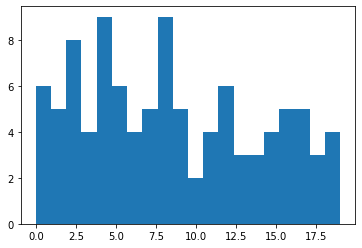

Neighbors = 4
Count of observations in each cluster (sorted): [10, 9, 9, 8, 7, 7, 6, 5, 4, 4, 4, 4, 4, 4, 3, 3, 3, 2, 2, 2]


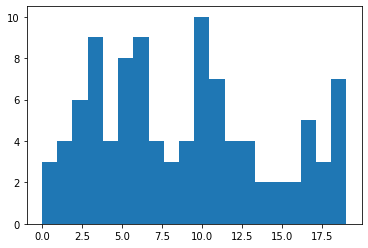

Neighbors = 5
Count of observations in each cluster (sorted): [10, 8, 7, 7, 7, 6, 6, 6, 5, 5, 5, 4, 4, 3, 3, 3, 3, 3, 3, 2]


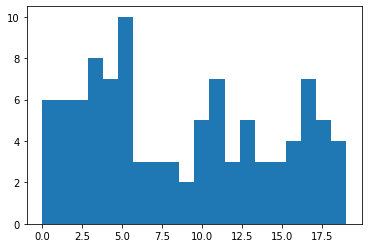

Neighbors = 6
Count of observations in each cluster (sorted): [10, 9, 8, 8, 6, 6, 5, 5, 5, 5, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3]


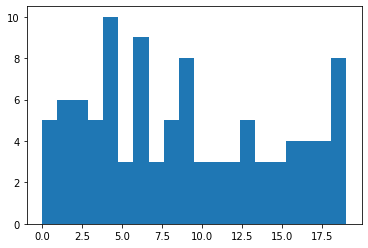

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,48,15,4,4,3,3,3,3,2,2,2,2,2,1,1,1,1,1,1,1
1,9,9,8,6,6,6,5,5,5,5,5,4,4,4,4,4,3,3,3,2
2,10,9,9,8,7,7,6,5,4,4,4,4,4,4,3,3,3,2,2,2
3,10,8,7,7,7,6,6,6,5,5,5,4,4,3,3,3,3,3,3,2
4,10,9,8,8,6,6,5,5,5,5,4,4,4,3,3,3,3,3,3,3


In [33]:
arr = []
for n_neighbors in np.arange(2,7):
    graph = kneighbors_graph(tree, n_neighbors=n_neighbors, mode='connectivity', include_self=True)
    spc = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=42)
    labels = spc.fit_predict(graph) 
    
    print("="*50)
    print(f"Neighbors = {n_neighbors}")
    
    count_labels = []
    for i in np.arange(n_clusters):
        # print(f"Label: {i}, Count: {np.count_nonzero(labels==i)}")
        count_labels.append(np.count_nonzero(labels==i))
    
    sorted_labels = sorted(count_labels, reverse=True)
    print(f"Count of observations in each cluster (sorted): {sorted_labels}")
    arr.append(sorted_labels)
    plt.hist(labels, bins=n_clusters)
    plt.show()       
    
arr = np.asarray(arr)
pd.DataFrame(arr)